<h1> Creating small language model from scratch </h2>

## Introduction

This notebook implements a simple, neural network-based Language Model from scratch, using the PyTorch library. The project aims to demonstrate key concepts in Natural Language Processing (NLP) and deep learning mechanisms, such as:
* Loading and preprocessing text data.
* Building a vocabulary and mapping words to indices.
* Creating a training dataset (context-next word pairs).
* Defining a simple neural network architecture.
* Implementing the training loop, loss function, and backpropagation.
* Evaluating the model using perplexity.
* Visualizing word embeddings.

The project is intentionally implemented "from scratch" to highlight the functioning of individual PyTorch components and deep learning mechanisms.

### 1. Data Preparation

In this section, we load text data from the `sentences.txt` file and then perform preliminary processing, which includes tokenization and vocabulary building.

In [727]:
# Loading text data from the 'sentences.txt' file.
# It is expected that each line in the file represents one sentence.
with open('sentences.txt', 'r') as infile:
    sentences = infile.readlines()
with open('sentences.txt', 'r') as infile:
    sentences = infile.readlines()

    words = []
    for i in range(len(sentences)):
        words_in_line = sentences[i].split()
        words.extend(words_in_line)
        sentences[i] = sentences[i].split()

# Creating list of single words
words = list(set(words))
words[:15]

['pluto',
 'banjos',
 'offense',
 'unexpected',
 'etched',
 'symbols',
 'rapidly',
 'echo',
 'elevator',
 'Smith',
 'roasting',
 "zino's",
 'floors',
 'outwardly',
 'snorkel']

### 2. Vocabulary Creation

Here, we build a vocabulary that maps each unique word to a unique integer index (stoi - string-to-integer) and an index back to a word (itos - integer-to-string). This is essential for the neural network to process text as numerical data.
In this implementation, we treat the period `.` as a special token representing the end of a sentence, which helps the model understand sequence boundaries.

In [728]:
itos = {}
for i, s in enumerate(words):
    itos[i] = s

In [729]:
sentences[:1]

[['i',
  "didn't",
  'know',
  'what',
  'to',
  'wear',
  'to',
  'my',
  'best',
  "friend's",
  'funeral',
  '.']]

In [730]:
stoi = {}
for i, s in enumerate(words):
    stoi[s] = i

In [731]:
stoi['.']

1598

In [732]:
len(stoi)

4076

In [733]:
itos[len(stoi)+1] = ' '

In [734]:
import torch

### 3. Building the Training and Test Dataset

In this section, we define the `building_the_dataset` function, which transforms raw sentences into input-output pairs, ready for training the language model. Each pair consists of:
* **Input (X)**: The context (a sequence of preceding words).
* **Output (Y)**: The next word that the model is supposed to predict.

We use `block_size` (context window size) to determine the length of the input sequence.
The data is then split into training and test sets to evaluate the model's generalization ability.

In [735]:
def building_the_dataset(sentences):
    block_size = 3
    X, Y = [], []

    for s in sentences:
        context = [stoi['.']] * block_size
        for w in s:
            ix = stoi[w]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

In [736]:
# Creating training and test set
import random
random.seed(42)

random.shuffle(sentences)
n1 = int(0.8 * len(sentences))

Xtr, Ytr = building_the_dataset(sentences[:n1])
Xtest, Ytest = building_the_dataset(sentences[n1:])

torch.Size([17639, 3]) torch.Size([17639])
torch.Size([4574, 3]) torch.Size([4574])


### 4. Data Analysis

After splitting the data, we check the sizes of the created datasets and identify words that appear in the validation (test) set but did not appear in the training set. This is important because the model will not be able to correctly process words it "hasn't seen" during training.

In [737]:
from collections import Counter
# Analyze the word distribution
print(f"Train vocab size: {len(set(word for sent in sentences[:n1] for word in sent))}")
print(f"Val vocab size: {len(set(word for sent in sentences[n1:] for word in sent))}")

# Check the most frequent words in the validation set that do not appear in the training set
train_words = set(word for sent in sentences[:n1] for word in sent)
val_words = Counter(word for sent in sentences[n1:] for word in sent)
unknown_words = {w: count for w, count in val_words.items() if w not in train_words}
print(f"Top unknown words: {dict(list(sorted(unknown_words.items(), key=lambda x: x[1], reverse=True))[:10])}")

Train vocab size: 3605
Val vocab size: 1480
Top unknown words: {'behind': 3, 'peanut': 3, 'sell': 3, 'say,': 2, 'you,': 2, 'sweet': 2, 'hunting': 2, 'balanced': 2, 'boyfriend': 2, 'loves': 2}


In [738]:
# How much percent validation words to unknown?
unknown_count = sum(unknown_words.values())
total_val_words = sum(val_words.values())
print(f"Unknown words: {unknown_count}/{total_val_words} ({unknown_count/total_val_words*100:.1f}%)")

# Most occuring words in validation
print("Top 10 words in validation set:")
for word, count in val_words.most_common(10):
    print(f"  {word}: {count}")

Unknown words: 498/4574 (10.9%)
Top 10 words in validation set:
  .: 533
  the: 225
  she: 110
  he: 79
  in: 68
  a: 65
  to: 63
  traditional: 56
  created: 49
  on: 41


In [739]:
import torch.nn.functional as F
import matplotlib.pyplot as plt 

In [740]:
len(words)

4076

### 5. Neural Network Model Definition

The language model is a simple neural network consisting of the following components:
* **Embedding Layer (`C`)**: Transforms word indices into dense vectors (embeddings) that represent their semantic meaning. The embedding dimension (`n_embd`) determines the size of these vectors.
* **Hidden Layers**: Consist of weights (`W1`, `W2`, `W3`) and biases (`b1`, `b2`, `b3`). They process the embeddings, learning complex relationships between words. They use the `torch.tanh` activation function for non-linearity.
* **Output Layer**: Generates logits (unnormalized probabilities) for each word in the vocabulary. The logits are then used to calculate the loss using the `F.cross_entropy` function.

All model parameters are initialized randomly.

In [741]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(words), 3), generator=g)
W1 = torch.randn(9, 100, generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(100, 100, generator=g)
b2 = torch.randn(100, generator=g)
W3 = torch.randn(100, len(words), generator=g)
b3 = torch.randn(len(words), generator=g)
parameters = [C, W1, b1, W2, b2, W3, b3]

In [742]:
sum(p.nelement() for p in parameters) # number of parametres

435004

In [743]:
for p in parameters:
    p.requires_grad = True

In [744]:
lossi = []
stepi = []

### 6. Model Training

In this section, we define the training loop. The model learns by iteratively adjusting its weights to minimize the loss function.

**Training steps:**
1.  **Mini-batch Selection**: Randomly select a subset of training data (mini-batch) in each iteration.
2.  **Forward Pass**: Data is passed through the neural network, generating predictions (logits).
3.  **Loss Calculation**: We calculate the loss (in this case, Cross-Entropy Loss), which measures the difference between the model's predictions and the actual next words.
4.  **Backward Pass (Backpropagation)**: We compute the gradients of the loss with respect to the model's weights.
5.  **Weight Update**: Model weights are updated in a direction that minimizes the loss, using an optimizer (here, a simple gradient descent implementation).
6.  **Perplexity Evaluation**: Perplexity is an evaluation metric for language models; the lower it is, the better the model. It represents the geometric mean of the inverse probability of correctly predicted words.

In [885]:
for i in range(1000):
    #creating batches
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 9) @ W1 + b1)
    l1 = h @ W2 + b2
    logits = l1 @ W3 + b3
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update
    stepi.append(i)
    for p in parameters:
        p.data += -0.002*p.grad
    
    lossi.append(loss.log10().item())

print(f'Loss {loss.item()}')
perplexity = loss.exp()
print(f'Perplexity {perplexity.item()}')


Loss 4.6416335105896
Perplexity 103.713623046875


Text(0.5, 1.0, 'Loss Curve in Logarithmic Scale')

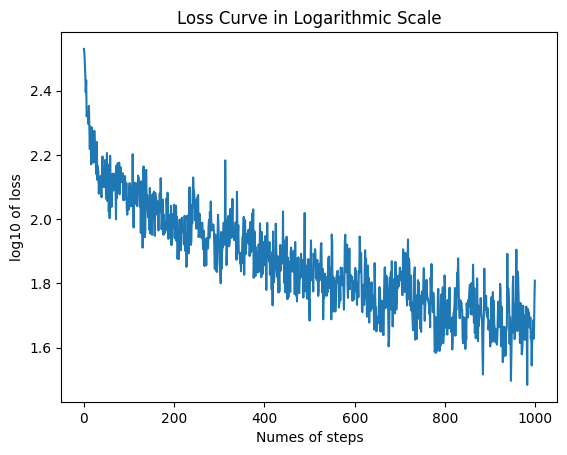

In [746]:
plt.plot(stepi, lossi)
plt.xlabel('Numes of steps')
plt.ylabel('log10 of loss')
plt.title("Loss Curve in Logarithmic Scale")

### 7. Training Results

After training, we check the final loss value on the training and test sets. A low loss value and low perplexity indicate that the model has successfully learned language patterns from the provided data.

Ideally, the loss on the training set should decrease, and the loss on the validation set should also be low and not increase (to avoid overfitting).

In [886]:
# validation set
emb = C[Xtest] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 9) @ W1 + b1)
l1 = h @ W2 + b2
logits = l1 @ W3 + b3
loss = F.cross_entropy(logits, Ytest)

print(f'Loss {loss.item()}')

perplexity = loss.exp()
print(f'Perplexity {perplexity.item()}')

Loss 6.293804168701172
Perplexity 541.208251953125


### 8. Sampling from the model
Generating New Sequences

In [887]:
g = torch.manual_seed(2137)
for i in range(10):
    out = []
    context = [stoi['.']] * 3

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 +b1)
        l1 = h @ W2 + b2
        logits = l1 @ W3 + b3
        probs = F.softmax(logits/0.8, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(ix)
        out.append(len(stoi)+1)
        context = context[1:] + [ix]

        if ix == stoi['.']:
            break
    
    print(''.join(itos[i] for i in out))


the textile created vocabulary steel . 
she auklets bred to . 
the instrument maker shaped guitar combined . 
he basic pet patterns . 
. 
the clockmaker were jaegers an henchman anticipated but . 
she metalworker bred . 
he terns bred . 
the weaver created after . 
that instrument maker ambition bypass she would . 


### 9. Predicting Next Word in My Own Text: Interactive Text Completion and Model Exploration
In this section, we move from passive observation of training metrics to an active, interactive demonstration of the model's learned capabilities. Here, you will have the opportunity to provide your own custom text as input (a "prompt") to the trained language model.

The model will then utilize the patterns and relationships it has learned during training to predict the most probable next word, effectively completing your input. This allows for a dynamic exploration of how the model "thinks" and generates language based on the context you provide. It's a practical way to observe the model's understanding of grammar, semantics, and common linguistic sequences in real-time. By experimenting with different prompts, you can gain deeper insights into the nuances of the model's learned representations and its ability to generalize to unseen text.

In [888]:
# My text
tex = "The cat is running"

In [942]:
text = tex.split()
cont = []
block_size = 3
for i in range(len(text)):
    if len(text) - i <=3:
        cont.append(stoi[text[i]])

emb = C[torch.tensor([cont])]
h = torch.tanh(emb.view(1, -1) @ W1 + b1)
l1 = h @ W2 + b2
logits = l1 @ W3 + b3
probs = F.softmax(logits, dim=1)
ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
print(f'{tex} {itos[ix]}')

The cat is running to


In [943]:
probs_flat = probs[0]  
sorted_probs, sorted_indices = torch.sort(probs_flat, descending=True)
print('Propability of next word occuring:\n')
for i in range(10):
    prob = sorted_probs[i].item()
    idx = sorted_indices[i].item()
    wordz = itos[idx]
    print(f"{i+1:2d}. {wordz:15s} {prob:.4f}")

Propability of next word occuring:

 1. .               0.0719
 2. were            0.0312
 3. a               0.0301
 4. the             0.0246
 5. was             0.0222
 6. big             0.0141
 7. in              0.0117
 8. to              0.0111
 9. me              0.0108
10. bred            0.0107


### 10. Vizualizing selected words in the embedding space

In [945]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

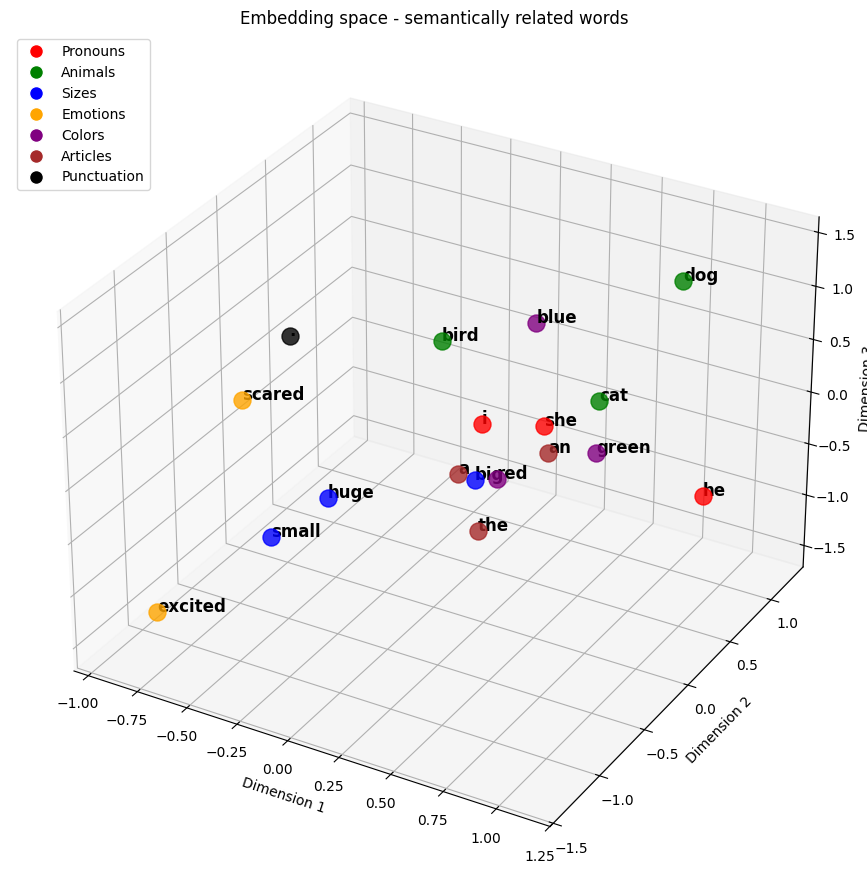

In [ ]:
# Selected semantically related words
interesting_words = [
   "he", "she", "i",              # pronouns
   "cat", "dog", "bird",          # animals  
   "big", "small", "huge",        # sizes
   "excited", "scared",           # emotions
   "red", "blue", "green",        # colors
   "the", "a", "an",              # articles
   "."                            # punctuation
]

# Check which words exist in the vocabulary and retrieve their embeddings
existing_words = [word for word in interesting_words if word in stoi]
indices = [stoi[word] for word in existing_words]
embeddings = C[indices].detach().numpy()

# print(f"Found words: {existing_words}")
# print(f"Not found: {[word for word in interesting_words if word not in existing_words]}")

# Create a 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Different colors for different categories
colors = ['red', 'red', 'red',                   # pronouns - red
         'green', 'green', 'green',              # animals - green  
         'blue', 'blue', 'blue',                 # sizes - blue
         'orange', 'orange',                     # emotions - orange
         'purple', 'purple', 'purple',           # colors - purple
         'brown', 'brown', 'brown',              # articles - brown
         'black']                                # punctuation - black

# Match colors to existing words
word_colors = []
for word in existing_words:
   if word in ["he", "she", "i"]:
       word_colors.append('red')
   elif word in ["cat", "dog", "bird"]:
       word_colors.append('green')
   elif word in ["big", "small", "huge"]:
       word_colors.append('blue')
   elif word in ["excited", "scared"]:
       word_colors.append('orange')
   elif word in ["red", "blue", "green"]:
       word_colors.append('purple')
   elif word in ["the", "a", "an"]:
       word_colors.append('brown')
   elif word == ".":
       word_colors.append('black')
   else:
       word_colors.append('gray')

# Add points with colors by category
for i, (word, color) in enumerate(zip(existing_words, word_colors)):
   ax.scatter(embeddings[i, 0], 
             embeddings[i, 1], 
             embeddings[i, 2],
             c=color, 
             s=150,
             alpha=0.8)
   
   # Add word labels
   ax.text(embeddings[i, 0], 
           embeddings[i, 1], 
           embeddings[i, 2], 
           word, 
           fontsize=12,
           weight='bold')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Embedding space - semantically related words')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Pronouns'),
   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Animals'),
   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Sizes'),
   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Emotions'),
   Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Colors'),
   Line2D([0], [0], marker='o', color='w', markerfacecolor='brown', markersize=10, label='Articles'),
   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Punctuation')
]

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

plt.tight_layout()
plt.show()


This 3D plot shows the embeddings of selected semantically related words.
Words are grouped by category (e.g., pronouns, animals, emotions, colors), and each group is color-coded for clarity.

We can observe that:

- Words from the same semantic category tend to cluster together.

 - Articles such as "a", "an", and "the" are located near the center of the embedding space, likely due to their high frequency and broad contextual usage across many types of phrases.

- Punctuation (e.g., the period symbol ".") appears more isolated, reflecting its distinct syntactic role.

This suggests that the model has captured meaningful patterns in how words are used, placing them accordingly in the embedding space.

Such visualizations provide valuable insight into how language models numerically represent word meaning and context.

## Summary

This project successfully demonstrates the basics of building a small language model. Despite its simplicity, the model is able to learn meaningful word representations.
